# Snapshots of mslp (contours), 10m wind (arrows), and 6hr precip (shading)

Christoph Braun, 2023-05


for case CTL

3 time steps:
- day 4.5
- day 6.5
- day 7.5

native triangular grid

cyclone centered

### Load required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import xarray as xr
import numpy as np
import pandas as pd

from collections import defaultdict

from numba import njit

### Define dicts to access data

In [2]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs


expname = {
      1: 'CTL',    
      2: '4K',
      3: '4K_qvCTL',
      4: 'Tanom',
      5: 'Tanom_TR',
      6: 'Tanom_PO'
         }

exp80 = { 
      1:'channel_80km_0001',
      2:'channel_80km_0002',
      3:'channel_80km_0003',
      4:'channel_80km_0004',
      5:'channel_80km_0005',
      6:'channel_80km_0006',
      }

exp2 = { 
      1:'channel_2km_0001',
      2:'channel_2km_0002',
      3:'channel_2km_0003',
      4:'channel_2km_0004',
      5:'channel_2km_0005',
      6:'channel_2km_0006',
      }


### Set experiments to load data for

In [3]:
experiments = [exp80[1],exp2[1]]

### Set domain parameters

In [4]:
# desired latitudinal extent of data
latmin = 20
latmax = 65

# longitudinal extent of data
lon_min=12.5
lon_ext=51
lon_max=lon_min+lon_ext

### Set timesteps of interest

In [5]:
t_plot = [6.25, 6.5 ,6.75]

### Read in track data

In [6]:
def read_track_data(exp,track_dur,track_lon,track_lat,track_pmin):

    # path
    path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

    df_track = pd.read_csv(path_track+'Track_for_'+exp+'_6hrly_1x1latlon.csv')
    
    # extract vars of interest
    track_dur[exp]  = df_track['time']+1
    track_lon[exp]  = df_track['lon']
    track_lat[exp]  = df_track['lat']
    track_pmin[exp]  = df_track['pmin']
    
    return track_dur,track_lon,track_lat,track_pmin

In [7]:
track_dur  = {}
track_lon  = {}
track_lat  = {}
track_pmin = {}

for exp in experiments:
    track_dur,track_lon,track_lat,track_pmin = read_track_data(exp,track_dur,track_lon,track_lat,track_pmin)

####  Helper function for loading data

In [57]:
def createList(r1, r2, r3):
    return list(range(r1, r2+1, r3))

def load_iconsimulation(expid):
    
    print('Working on loading data for', expid)
    # set path to data
    path  = '/work/bb1152/Module_A/A6_CyclEx/sim_data/production'
    
    
    # 2d datasets
    
    fname = path+'/'+expid+'/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc'
        
    print(fname)
    ds_2d = xr.open_mfdataset(fname)
    
    ds = ds_2d[['pres_sfc',
             'pres_msl']] 
    
    if (expid in list(exp80.values())):
    
        ds = ds.isel(time=createList(36,216+1,6))  # day 2.5- 9, every 6 hr (starting from t=0)

    else :  #2-km experiments
    
        ds = ds.isel(time=slice(6,36+1))              # day 2.5-9, every 6 hr 
    # set relative time-axis

    ds["time"] = ds.time - 20210101
    
    return ds

### Load data

In [58]:
ds = {}

for exp in experiments:
    ds[exp] = load_iconsimulation(exp)

Working on loading data for channel_80km_0001
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0001/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc
Working on loading data for channel_2km_0001
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc


### Select required variables and timesteps

In [61]:
# Read the data from model outputs

lons = {}
lats = {}
time = {}
psfc = {}
mslp = {}
for exp in experiments:
    lons[exp]         = ds[exp].variables['lon'][:].to_numpy()
    lats[exp]         = ds[exp].variables['lat'][:].to_numpy()
    time[exp]         = ds[exp].variables['time'][:].to_numpy()
          
    psfc[exp]         = ds[exp].variables['pres_sfc'][:].to_numpy()

    mslp[exp]         = ds[exp].variables['pres_msl'][:].to_numpy()



### Define functions for plotting

In [29]:
def plot_tripcolor(r,c,ds,var,vmin,vmax,cmap,cbar=False):
    
    edgecolors = 'None'
    
    if cbar:
        cbar = ax[r,c].tripcolor(ds['vlon'],
                  ds['vlat'],
                  ds['vertex_of_cell'].transpose(),
                  facecolors=ds[var]*0.01,
                  vmin=vmin,
                  vmax=vmax,
                  edgecolors=edgecolors,
                 cmap=cmap)
        
        cbaxes = fig.add_axes([0.93, 0.2, 0.02, 0.6]) 
        plt.colorbar(cbar,
                     ax=ax[:,:],
                     #location='right',
                     cax = cbaxes,
                     shrink=0.5,
                    label='surface pressure (hPa)'
                    #label='6-hrly precip. [kg m-2 day-1]',
                   )
        
    else:
        ax[r,c].tripcolor(ds['vlon'],
                  ds['vlat'],
                  ds['vertex_of_cell'].transpose(),
                  facecolors=ds[var]*0.01,
                  vmin=vmin,
                  vmax=vmax,
                  edgecolors=edgecolors,
                  cmap=cmap)
    
    return

In [39]:
def plot_tricontour(r,c,ds,var,levels,scalefac,lw,contour_colors,zorder, clab=False):
    
    CS= ax[r,c].tricontour(ds['clon'],
               ds['clat'],
               ds[var]*scalefac,
               colors=contour_colors,
               levels=levels,
               linewidths=lw,zorder=zorder)
    if clab: 
        #clabels = plt.clabel(CS, CS.levels[::2], inline=False,fmt='%1.f', fontsize=8)
        clabels = plt.clabel(CS, [990, 1000], inline=False,fmt='%1.f', fontsize=8)
        [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]
    
    return

In [40]:
cmap_data = ["white","#98CBFE", "#0498FE", "#0F2CFF",
             "#00FF65", "#00CC01", "#009801", "#006500",
             "#FFFE31", "#FECC00", "#FF9800", "#FF6500",
             "#FE0400", "#FF0298", "#9833CB", "#650098"
             ]
#cmap_data = ['white',"#ffffd9", "#edf8b1", "#c7e9b4",
#             "#7fcdbb", "#41b6c4", "#1d91c0", "#225ea8",
#             "#253494", "#081d58" ]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')

### Plotting.

Check whether below plotting style can be kept for final manuscript figures.

In [41]:
import matplotlib.style as mplstyle
mplstyle.use('fast')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

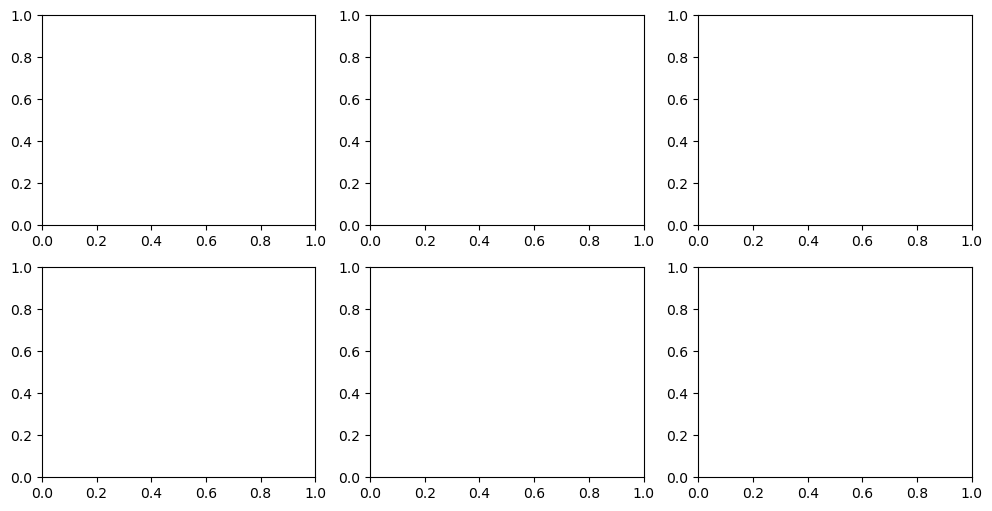

In [64]:
import matplotlib.patheffects as pe
fig = plt.figure(figsize=(12,6))#,layout="constrained")

# set up figure structure
nrows = 2
ncols = 3

gs = GridSpec(nrows, ncols, figure=fig, width_ratios=[1,1,1])
ax = np.zeros((nrows,ncols),dtype=object)

for r in range(0,nrows):
    for c in range(0,ncols):
        ax[r,c] = plt.subplot(gs.new_subplotspec((r, c)))

# fill figure with content

for r in range(0,nrows):
    for c in range(0,ncols):
        
        exp = experiments[r]
        t = t_plot[c]
        
        # Plot mslp as contour
        scalefac = 0.01
        plw = 1.5
        tlw = 1.1
        
        plevels=np.arange(940,1050,5)
        tlevels=np.arange(262,300,10)
        cmapt=('mediumblue', 'mediumblue', 'firebrick', 'firebrick')
        cmap = 'Spectral'
       
        cd = plt.contourf(lons[exp],lats[exp],mslp[exp][t]*0.01,plevels,cmap=cmap,extend='both',transform=ccrs.PlateCarree())
        cs = plt.contour(lons[exp],lats[exp],mslp[exp][t]*0.01,plevels,'k',transform=ccrs.PlateCarree())
        #plot_tricontour(r,c,ds_concat[exp][t],'pres_sfc',plevels,scalefac,plw,contour_colors='k',zorder=100, clab=True)
        
        
        #                    scale_units='inches') # factor required to obtain similar spacing
        
        # Add marker at cyclone center
        cen_lat =track_lat[exp][t_index[t]]
        cen_lon0 =track_lon[exp][t_index[t]]
        cen_pmin=track_pmin[exp][t_index[t]]
        
        print(cen_lon0)
        
        if cen_lon0 <= lon_min+lon_ext/2:
            cen_lon=cen_lon0
        else:
            cen_lon=cen_lon0
        ax[r,c].scatter(cen_lon, cen_lat, c='k', s=100, zorder=120)
        ax[r,c].scatter(cen_lon, cen_lat, c='r', s=50, zorder=120)
        ax[r,c].text(cen_lon, cen_lat-2,''+str(int(cen_pmin))+'', va='center',zorder=120, fontsize=12, weight='bold', 
         path_effects=[pe.withStroke(linewidth=3, foreground="white")])

        ax[r,c].axvline(x=cen_lon, color='r', linestyle='dotted')
        # Set limits, ticks, and labels
        #ax[r,c].set_xlim(lon_min,lon_max)
        ax[r,c].set_xlim(23,56)
        
        #lonticks = 20
        #ax[r,c].set_xticks([lon_min+lon_ext/2-lonticks,
        #                    lon_min+lon_ext/2,
        #                    lon_min+lon_ext/2+lonticks],
        #                   [-lonticks,0,lonticks])
        ax[r,c].set_ylim(42,59)
        #ax[r,c].set_yticks([20,40,60])
        
        if c==0:
            ax[r,c].set_ylabel('Latitude (°)',fontsize=13)
            
            xtxt = 0.05
            ytxt = 0.88
        else:
            ax[r,c].set_yticklabels('')
            
        if r ==0 and c ==0 :
            ax[r,c].text(xtxt,ytxt,'80 km',
                     ha='left',
                     weight='bold',fontsize=13,
                     bbox=dict(ec='k',fc='white'),
                     transform=ax[r,c].transAxes, zorder=50)
            
        if r ==1 and c== 0:
            ax[r,c].text(xtxt,ytxt,'2.5 km',
                     ha='left',
                     weight='bold',fontsize=13,
                     bbox=dict(ec='k',fc='white'),
                     transform=ax[r,c].transAxes, zorder=50)

        if r==1:
            ax[r,c].set_xlabel('Longitude (°)',fontsize=13)
        else:
            ax[r,c].set_xticklabels('')
            if c==0:
                ax[r,c].set_title('Day '+str(t),weight='bold',fontsize=13)
            else:
                ax[r,c].set_title('Day '+str(t),weight='bold',fontsize=13)
                
plt.text(0.03, 1.09, '(a)', ha='center', va='top', transform=ax[0,0].transAxes, fontsize=13) 
plt.text(0.03, 1.09, '(b)', ha='center', va='top', transform=ax[0,1].transAxes, fontsize=13)
plt.text(0.03, 1.09, '(c)', ha='center', va='top', transform=ax[0,2].transAxes, fontsize=13) 
plt.text(0.03, 1.09, '(d)', ha='center', va='top', transform=ax[1,0].transAxes, fontsize=13) 
plt.text(0.03, 1.09, '(e)', ha='center', va='top', transform=ax[1,1].transAxes, fontsize=13) 
plt.text(0.03, 1.09, '(f)', ha='center', va='top', transform=ax[1,2].transAxes, fontsize=13)

plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
#figpath = '/work/bb1152/Module_A/A6_CyclEx/figures/drafts/'
figpath = './'
plt.savefig(figpath+'FigR3_sfcp_diff_80vs2p5km_interpolatted.png',
                bbox_inches='tight',
                dpi=200)